#intro to siamse network



1.   Siamese is a architecture with two parallel layers. In this architecture instead of model learning to classify it's inputs using classification loss  functions, the model learns to differentiate between two given inputs.

2.   It compares two inputs based on a similarity matric and check weather they are same or not.

3. We learn image embedding using metric base approach with Siamese neural networks, and then reuse that network's features for one-shot learning without fine-tuning or retraining.

4. A Siamese network consists of two identical neural networks that share similar parameters, each head taking input data point. 

5. In the middle layer we extract similar kind of features, as the weights and biases are the same. The last layer of this network are fed to contrastive loss function layer,  which calculates the similarity between two points.
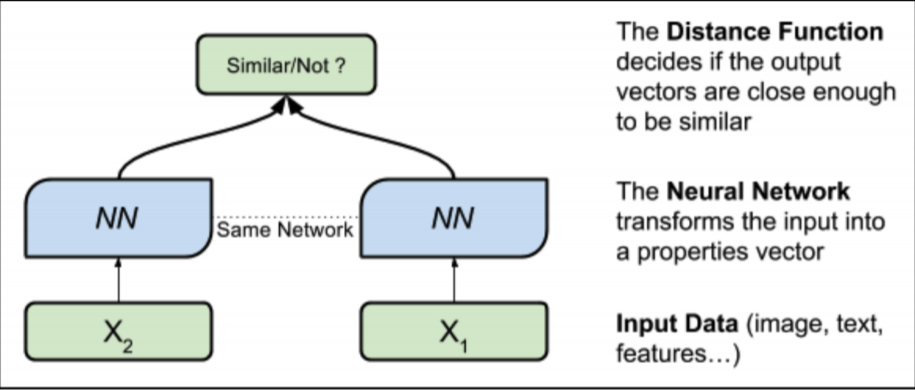

#Libraries required

In [1]:
# -*- encoding: utf-8 -*-
import argparse
import torch
import torchvision.datasets as dsets
import random
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torchvision import transforms
import pickle
import torch
import torch.nn as nn

#preprocess 

In [2]:
class Dataset(object):
  def __init__(self, x0, x1, label):
    self.size = label.shape[0]
    self.x0 = torch.from_numpy(x0)
    self.x1 = torch.from_numpy(x1)
    self.label = torch.from_numpy(label)
  def __getitem__(self, index):
    return (self.x0[index],
    self.x1[index],
    self.label[index])
  def __len__(self):
    return self.size

#create pairs

In [9]:
def create_pairs(data, digit_indices):
  x0_data = []
  x1_data = []
  label = []
  n = min([len(digit_indices[d]) for d in range(10)]) - 1
  for d in range(10): # for MNIST dataset: as we have 10 digits
    for i in range(n):
      z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
      x0_data.append(data[z1] / 255.) # Image Preprocessing      Step
      x1_data.append(data[z2] / 255.) # Image Preprocessing      Step
      label.append(1)
      inc = random.randrange(1, 10)
      dn = (d + inc) % 10
      z1, z2 = digit_indices[d][i], digit_indices[dn][i]
      x0_data.append(data[z1] / 255.) # Image Preprocessing      Step
      x1_data.append(data[z2] / 255.) # Image Preprocessing      Step
      label.append(0)
  x0_data = np.array(x0_data, dtype=np.float32)
  x0_data = x0_data.reshape([-1, 1, 28, 28])
  x1_data = np.array(x1_data, dtype=np.float32)
  x1_data = x1_data.reshape([-1, 1, 28, 28])
  label = np.array(label, dtype=np.int32)
  return x0_data, x1_data, label

#iterator function

In [4]:
def create_iterator(data, label, batchsize, shuffle=False):
 digit_indices = [np.where(label == i)[0] for i in range(10)]
 x0, x1, label = create_pairs(data, digit_indices)
 ret = Dataset(x0, x1, label)
 return ret

# contrastive_loss_function 

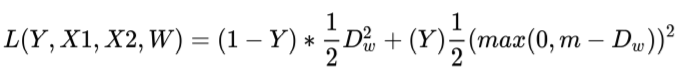

Where Dw is

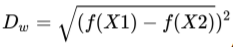

In [11]:
def contrastive_loss_function(x0, x1, y, margin=1.0):
 # euclidean distance
 diff = x0 - x1
 dist_sq = torch.sum(torch.pow(diff, 2), 1)
 dist = torch.sqrt(dist_sq)
 mdist = margin - dist
 dist = torch.clamp(mdist, min=0.0)
 loss = y * dist_sq + (1 - y) * torch.pow(dist, 2)
 loss = torch.sum(loss) / 2.0 / x0.size()[0]
 return loss

#siamse network

In [5]:
class SiameseNetwork(nn.Module):
  def __init__(self,flag_kaf=False):

    super(SiameseNetwork, self).__init__()
    self.cnn1 = nn.Sequential(
    nn.Conv2d(1, 20, kernel_size=5),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(20, 50, kernel_size=5),
    nn.MaxPool2d(2, stride=2))
    self.fc1 = nn.Sequential(
    nn.Linear(50 * 4 * 4, 500),
    nn.ReLU(inplace=True),
    nn.Linear(500,10),
    nn.Linear(10, 2))
  def forward_once(self, x):

    output = self.cnn1(x)
    output = output.view(output.size()[0], -1)
    output = self.fc1(output)
    return output

  def forward(self, input1, input2):
    output1 = self.forward_once(input1)
    output2 = self.forward_once(input2)
    return output1, output2


#dataset calling
Reduce the MNIST dataset and choose 2000 the random points 

In [7]:
batchsize=128
train = dsets.MNIST(root='../data/',train=True,download=True)
test =  dsets.MNIST(root='../data/',train=False,transform=transforms.Compose([transforms.ToTensor(),]))
indices= np.random.choice(len(train.train_labels.numpy()), 2000,
replace=False)
indices_test= np.random.choice(len(test.test_labels.numpy()), 100,
replace=False)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


#teaining and test set iterators

used contrastive_loss_function as a criterion

In [12]:
train_iter =create_iterator(train.train_data.numpy()[indices],train.train_labels.numpy()[indices],batchsize)
test_iter =create_iterator(test.test_data.numpy()[indices_test],test.test_labels.numpy()[indices_test],batchsize)

# call model
model = SiameseNetwork()
learning_rate = 0.01 # learning rate for optimization

momentum = 0.9 # momentum
# Loss and Optimizer
criterion = contrastive_loss_function # we will use contrastive loss function as defined above
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,momentum=momentum)
# creating a train loader, and a test loader.
train_loader =torch.utils.data.DataLoader(train_iter,batch_size=batchsize,shuffle=True)
test_loader = torch.utils.data.DataLoader(test,batch_size=batchsize,shuffle=True)


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


#train

In [17]:
train_loss = []
epochs =100
for epoch in range(epochs):
 print('Train Epoch:'+str(epoch)+"------------------>")
 for batch_idx, (x0, x1, labels) in enumerate(train_loader):
  labels = labels.float()
  x0, x1, labels = Variable(x0), Variable(x1), Variable(labels)
  output1, output2 = model(x0, x1)
  loss = criterion(output1, output2, labels)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  train_loss.append(loss.item())
  if batch_idx % batchsize == 0:
    print('Epoch: {} \tLoss: {:.6f}'.format(epoch,loss.item()))


Train Epoch:0------------------>
Epoch: 0 	Loss: 0.227862
Train Epoch:1------------------>
Epoch: 1 	Loss: 0.183963
Train Epoch:2------------------>
Epoch: 2 	Loss: 0.111803
Train Epoch:3------------------>
Epoch: 3 	Loss: 0.091035
Train Epoch:4------------------>
Epoch: 4 	Loss: 0.079111
Train Epoch:5------------------>
Epoch: 5 	Loss: 0.076066
Train Epoch:6------------------>
Epoch: 6 	Loss: 0.080962
Train Epoch:7------------------>
Epoch: 7 	Loss: 0.093462
Train Epoch:8------------------>
Epoch: 8 	Loss: 0.077666
Train Epoch:9------------------>
Epoch: 9 	Loss: 0.071070
Train Epoch:10------------------>
Epoch: 10 	Loss: 0.055629
Train Epoch:11------------------>
Epoch: 11 	Loss: 0.049707
Train Epoch:12------------------>
Epoch: 12 	Loss: 0.052704
Train Epoch:13------------------>
Epoch: 13 	Loss: 0.065954
Train Epoch:14------------------>
Epoch: 14 	Loss: 0.050916
Train Epoch:15------------------>
Epoch: 15 	Loss: 0.042198
Train Epoch:16------------------>
Epoch: 16 	Loss: 0.048550


#Plot training accuracy wrt epochs

In [18]:
def plot_loss(train_loss,name="train_loss.png"):
 plt.plot(train_loss, label="train loss")
 plt.legend()
 plt.show()
def plot_mnist(numpy_all,numpy_labels,name="./embeddings_plot.png"):
  c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff','#ff00ff', '#990000', '#999900', '#009900', '#009999']
  for i in range(10):
   f = numpy_all[np.where(numpy_labels == i)]
   plt.plot(f[:, 0], f[:, 1], '.', c=c[i])
  plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
  plt.savefig(name)


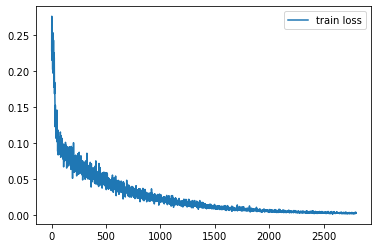

In [19]:
plot_loss(train_loss)


#Test

In [22]:
def test_model(model):
  model.eval()
  all_ = []
  all_labels = []
  with torch.no_grad():
    for batch_idx, (x, labels) in enumerate(test_loader):
      x, labels = Variable(x), Variable(labels)
      output = model.forward_once(x)
      all_.extend(output.data.cpu().numpy().tolist())
      all_labels.extend(labels.data.cpu().numpy().tolist())
    numpy_all = np.array(all_)
    numpy_labels = np.array(all_labels)
    return numpy_all, numpy_labels
def testing_plots(model):
  dict_pickle={}
  numpy_all, numpy_labels = test_model(model)
  dict_pickle["numpy_all"]=numpy_all
  dict_pickle["numpy_labels"]=numpy_labels
  plot_mnist(numpy_all, numpy_labels)


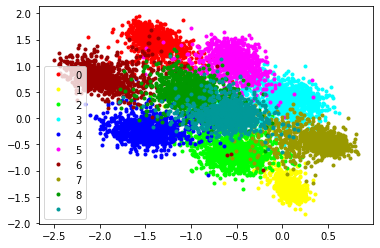

In [23]:
testing_plots(model)